# Fraud Detection

## 1. Background<br>
Fraud Detection has been subjected to great interest to the public. One way to generate a solution is to develop a machine learning model to detect a fraud.

## 2. Objective <br>
The objective of this work is <br> 

- to generate a classification model specific to the data-set, <i>Synthetic data from a financial payment system</i><br>
- to evaluate the model's accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline 

In [2]:
df = pd.read_csv('../input/bs140513_032310.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


## 3. Data Observation

### 3.1 Data Sanity Check <br>
The data is clean, and contains no missing data (NaN).

In [3]:
df.isnull().values.any()

False

### 3.2 Numbers and Percentage of Fraud<br>
Number of Transactions observed<br>
- Total: 601843<br>
- Normal: 594643<br>
- Fraud: 7200<br>

Percentage, fraud vs normal transaction<br>
- Normal: 98.79%<br>
- Fraud: 1.21%<br>

In [4]:
# Counting frequency and percentage of frad
df_fraud= df[df['fraud']==1]
num_transaction_total, num_transaction_fraud = len(df), len(df_fraud)
num_transaction_total, num_transaction_fraud

(594643, 7200)

In [5]:
percent_fraud = round(num_transaction_fraud / num_transaction_total * 100, 2)
percent_safe = 100 - percent_fraud
percent_fraud, percent_safe

(1.21, 98.79)

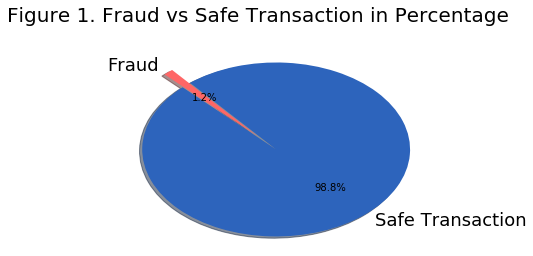

In [6]:
# plotting pie chart for percentage comparision: 'fraud' vs 'safe-transaction'
fig1, ax1 = plt.subplots()

plt.title("Figure 1. Fraud vs Safe Transaction in Percentage", fontsize = 20)
labels = ['Fraud', 'Safe Transaction']
sizes = [percent_fraud, percent_safe]
explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True, explode=explode, startangle=130, colors = ['#ff6666', '#2d64bc'])
texts[0].set_fontsize(18)
texts[1].set_fontsize(18)

import matplotlib
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]

### 3.3 General Parameters Overview <br>
This section will look at<br>
- Which parameters are features, and which are target<br>
- How many unique entries are found for each parameter(in each column)<br>

Looking at these will provide general overview of the data-set's parameters.<br>
If parameters that only has 1 unique entry could be disregarded in the classification, as they will have no influence.<br>
Insightful judgement can be made in this stage to filter out a parameter that are affected 'data leakage.'


In [7]:
# Extracting # of unique entires per column and their sample values
num_unique = []
sample_col_values = []
for col in df.columns:
    num_unique.append(len(df[col].unique()))  # Counting number of unique values per each column
    sample_col_values.append(df[col].unique()[:3])  # taking 3 sample values from each column              

In [8]:
# combining the sample values into a a=single string (commas-seperated)
# ex)  from ['hi', 'hello', 'bye']  to   'hi, hello, bye'
col_combined_entries = []
for col_entries in sample_col_values:
    entry_string = ""
    for entry in col_entries:
        entry_string = entry_string + str(entry) + ', '
    col_combined_entries.append(entry_string[:-2])

In [9]:
# Generating a list 'param_nature' that distinguishes features and targets
param_nature = []
for col in df.columns:
    if col == 'fraud':
        param_nature.append('Target')
    else:
        param_nature.append('Feature')

In [10]:
# Generating Table1. Parameters Overview
df_feature_overview = pd.DataFrame(np.transpose([param_nature, num_unique, col_combined_entries]), index = df.columns, columns = ['Parameter Nature', '# of Unique Entries', 'Sample Entries (First three values)'])
df_feature_overview

,Parameter Nature,# of Unique Entries,Sample Entries (First three values)
step,Feature,180,"0, 1, 2"
customer,Feature,4112,"'C1093826151', 'C352968107', 'C2054744914'"
age,Feature,8,"'4', '2', '3'"
gender,Feature,4,"'M', 'F', 'E'"
zipcodeOri,Feature,1,'28007'
merchant,Feature,50,"'M348934600', 'M1823072687', 'M50039827'"
zipMerchant,Feature,1,'28007'
category,Feature,15,"'es_transportation', 'es_health', 'es_otherser..."
amount,Feature,23767,"4.55, 39.68, 26.89"
fraud,Target,2,"0, 1"


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<b>Table 1. Parameters Overview</b>
<br><br>

<b> 3.3.1 General Parameters Overview: Interpretation </b> <br>

- 'zipcodeOri' and 'zipMerchant' can be disregarded as they only have 1 unique entry, thus does not affects the classification.<br>
- The parameter 'customer,' is also to be taken out, because it is affected by 'data leakage.' The one-time fraud victims are unlikely to be the victim of fraud again.


In [11]:
# Data filtering following the 'General Parameters Overview'
del df['zipcodeOri']
del df['zipMerchant']
del df['customer']

### 3.4 Parameter Sensitivity Analysis (Feature Importance)<br>
The preliminary decision tree modeling is performed to how influential each parameter is. Future analysis can emphasizes on the more important feature detected by this sensitivity analysis. The results of the sensitivity analysis is visually illustrated by Figure 2.

In [12]:
# copy dataframe for preliminary decision tree
df_fi = df
# Selecting Columns whose values are categorical (in practice, the strings)
col_categorical = df_fi.select_dtypes(include= ['object']).columns
# Converting data-type as 'category;
for col_name in col_categorical:
    df_fi[col_name] = df_fi[col_name].astype('category')
# Converting categorical entries to integers
df_fi[col_categorical] = df_fi[col_categorical].apply(lambda x: x.cat.codes)
# seperatign data columns and target columns
col_names = df_fi.columns.tolist()
col_names_data = col_names[0:len(col_names)-1]
col_name_target = col_names[-1]
# Declaring 'data-dataframe'  and 'target-dataframe'
X = df_fi[col_names_data]
y = df_fi[col_name_target]

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [14]:
# sorted-feature importances from the preliminary decision tree
ds_fi = pd.Series(dt.feature_importances_ , index = col_names_data).sort_values(ascending= False)

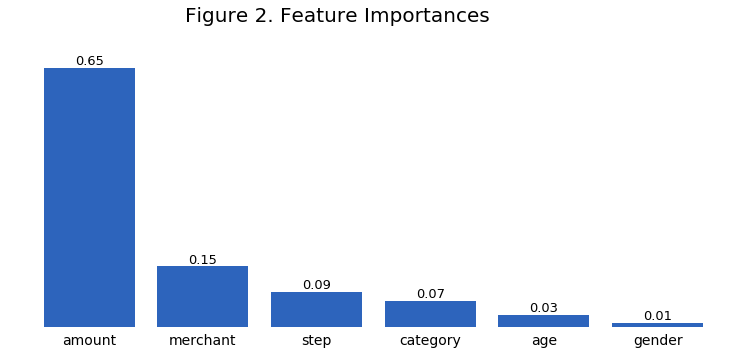

In [15]:
# plotting feature imporance bar-graph
fig2 = plt.figure(figsize=(13,5))

# Generating stacked bar-chart
bars_ft = plt.bar(range(len(ds_fi)), ds_fi, width = .8, color = '#2d64bc')

# Labeling
ttl = plt.title("Figure 2. Feature Importances", fontsize = 20).set_position([0.45, 1.1])
plt.xticks(range(len(ds_fi)), ds_fi.index, fontsize = 14)

# plot-dejunking
ax = plt.gca()
ax.yaxis.set_visible(False) # hide entire y axis (both ticks and labels)
ax.xaxis.set_ticks_position('none')  # hide only the ticks and keep the label
# hide the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# value displaying
rects = ax.patches  
labels = ds_fi.values.round(2)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize = 13)

### 3.5 Visualization of the dominant variable, <i> Transaction Amount</i> <br>
As Figure 2 shows, 'transaction amount' is the most infuential parameter in detecting (or classifying) a fraud. In this section, the 'transaction amount' is studied more closely. The following two will be looked at.<br>
- For different rage of transaction amount, what is the frequency distribution. (Figure 3)<br>
- For different rage of transaction amount, what is the percentage distribution. (Figure 4)<br>

In [16]:
num_bins = 15
tran_amount = df['amount']
n, bins, patches = plt.hist(tran_amount, num_bins, normed = False, stacked = True, facecolor= '#f26a6a', alpha=0.5)
plt.close()

In [17]:
n_fraud = np.zeros(num_bins)
for i in range(num_bins):
    for j in range(num_transaction_fraud):
        if bins[i] < df_fraud['amount'].iloc[j] <= bins[i+1]:
            n_fraud[i] += 1

In [18]:
range_amount = []
for i in range(num_bins):
    lower_lim, higher_lim = str(int(bins[i])), str(int(bins[i+1]))
    range_amount.append("$ " + lower_lim + " ~ " + higher_lim )

In [19]:
df_hist = pd.DataFrame(index = range_amount)
df_hist.index.name = 'Transaction Amount[$]'
df_hist['# Total'] = n
df_hist['# Fraud'] = n_fraud
df_hist['# Safe'] = df_hist['# Total'] - df_hist['# Fraud']
df_hist['% Fraud'] = (df_hist['# Fraud'] / df_hist['# Total'] * 100).round(2)
df_hist['% Safe'] = (df_hist['# Safe'] / df_hist['# Total'] * 100).round(2)
df_hist

,# Total,# Fraud,# Safe,% Fraud,% Safe
Transaction Amount[$],,,,,
$ 0 ~ 555,592793.0,5430.0,587363.0,0.92,99.08
$ 555 ~ 1110,1309.0,1257.0,52.0,96.03,3.97
$ 1110 ~ 1665,143.0,121.0,22.0,84.62,15.38
$ 1665 ~ 2221,81.0,75.0,6.0,92.59,7.41
$ 2221 ~ 2776,65.0,65.0,0.0,100.00,0.00
$ 2776 ~ 3331,59.0,59.0,0.0,100.00,0.00
$ 3331 ~ 3887,48.0,48.0,0.0,100.00,0.00
$ 3887 ~ 4442,48.0,48.0,0.0,100.00,0.00
$ 4442 ~ 4997,38.0,38.0,0.0,100.00,0.00


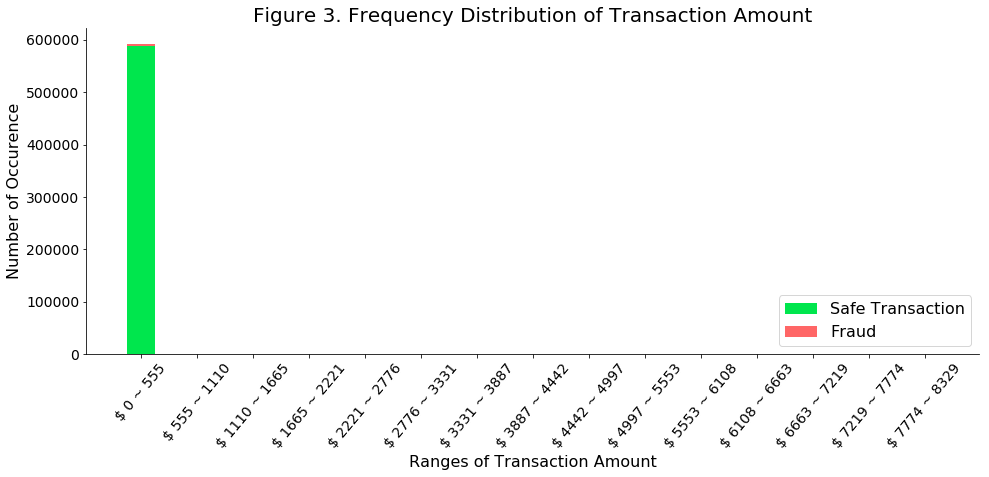

In [20]:
fig3 = plt.figure(figsize=(16,6))

# Generating stacked bar-chart
bars_fraud = plt.bar(range(num_bins), df_hist['# Safe'], width = 0.5, color = '#00e64d')
bars_safe = plt.bar(range(num_bins), df_hist['# Fraud'], width = 0.5, bottom = df_hist['# Safe'], color='#ff6666')

# Labeling
plt.title("Figure 3. Frequency Distribution of Transaction Amount", fontsize = 20)
plt.xticks(range(num_bins), range_amount, fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend((bars_fraud[0], bars_safe[0]), ('Safe Transaction', 'Fraud'), loc=4, fontsize = 16)
plt.xlabel('Ranges of Transaction Amount', fontsize=16)
plt.ylabel('Number of Occurence', fontsize=16)

# hiding top/right border
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

x = plt.gca().xaxis
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(50)

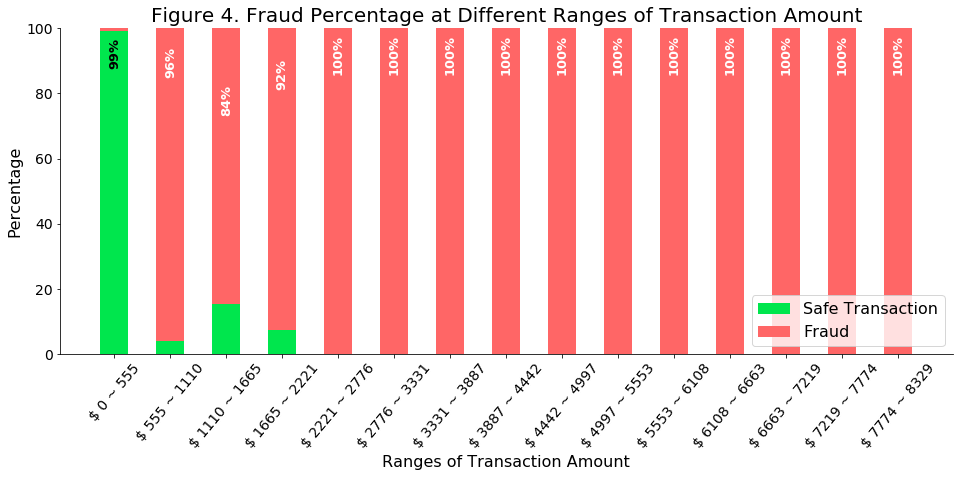

In [21]:
fig4 = plt.figure(figsize=(16,6))

# Generating stacked bar-chart
bars_fraud = plt.bar(range(num_bins), df_hist['% Safe'], width = 0.5, color = '#00e64d')
bars_safe = plt.bar(range(num_bins), df_hist['% Fraud'], width = 0.5, bottom = df_hist['% Safe'], color='#ff6666')

# Labeling
plt.title("Figure 4. Fraud Percentage at Different Ranges of Transaction Amount", fontsize = 20)
plt.xticks(range(num_bins), range_amount, fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend((bars_fraud[0], bars_safe[0]), ('Safe Transaction', 'Fraud'), loc=4, fontsize = 16)
plt.xlabel('Ranges of Transaction Amount', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.ylim(0, 100)
x = plt.gca().xaxis
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(50)

# hiding top/right border
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    

# bar-value display
for bar in bars_safe:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 5, str(int(bar.get_height())) + '%', 
                 ha='center', color='w', fontsize=13, rotation = 'vertical', weight = 'bold')
plt.gca().text(bars_fraud[0].get_x() + bars_fraud[0].get_width()/2, bars_fraud[0].get_height() - 5, str(int(bars_fraud[0].get_height())) + '%', 
                 ha='center', color='black', fontsize=13, rotation = 'vertical', weight = 'bold')

## Te be continued at my next availability.......